# Tekst zadatka

U fajlu spotify.csv dati su podaci o najpopularnijim pesmama na Spotify platformi 2023. godine. Varijable dataset-a su:
- track_name: naziv pesme
- released_year: godina izdanja
- in_spotify_playlists: na koliko playlista na spotify platformi se nalazi pesma
- in_spotify_charts: pozicije pesme na spotify rang listi
- streams: broj puštanja pesme
- in_apple_playlists: na koliko playlista na apple platformi se nalazi pesma
- in_apple_charts: pozicije pesme na apple rang listi
- bpm: mera brzine pesme (beats per minute)
- mode: karakter pesme (minor / major)
- energy: percipirani energetski nivo pesme
- instrumentalness: nivo instrumentalnosti
- liveness: nivo prisustva elemenata izvođenja uživo
- speechiness: Skalirana količina izgovorenih reči u pesmi

Potrebno je uraditi sledeće:
1. Napraviti podskup podataka koji ne sadrži pesme čija je skalirana količina izgovorenih reči
(speechiness) preko 60. Za sve naredne zahteve zadatka koristiti ovako dobijen dataset.
2. Odabrati atribute (promenljive) koji će biti uključeni u model klasterizacije i navesti razlog za njihov odabir ili
neodabir.
3. U dataset-u dobijenom na osnovu prethodna dva zahteva proveriti da li postoje nedostajuće
vrednosti (NA, “-”, ” ”, ili ””) i ako je moguće, zameniti ih adekvatnim vrednostima.
Prokomentarisati postupak zamene vrednosti, odnosno zašto je određeni metod zamene
vrednosti odabran. Tako dobijeni dataset eventualno dodatno obraditi da bi bio pogodan za
primenu metode klasterizacije.
4. Primenom dendrograma utvrditi najbolju vrednost za broj klastera (k) i linkage metodu. Uzeti euklidsku razdaljinu.
5. Izvršiti hijerarhijsku klasterizaciju za izabranu (tj. utvrđenu najbolju) vrednost za k i linkage metodu.
6. Interpretirati dobijene klastere (grupisane pesme) na osnovu: broja pesama po klasteru,
centara klastera, disperzije od centra.

**NAPOMENE**
- U produžetku je prikazano JEDNO moguće tačno rešenje, ali ne i jedino
- Dodati su i podnaslovi (headers) između blokova sa kodom da bi se lakše pratio zadatak, ali to nije neophodno uraditi na ispitu
- KLJUČNA stvar na ispitu je da se svaki korak objasni kratkim komentarima u kodu, jer inače neće biti priznat pun broj poena

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.cluster as cluster

## 1. Napraviti podskup podataka koji ne sadrži pesme čiji je speechiness preko 60

In [2]:
data = pd.read_csv('./data/spotify.csv')

#Pravimo novi dataset koji sadrži samo pesme čiji speechiness je manji od ili jednak 60
cl_data = data[data["speechiness"] <= 60].copy()

# Bacimo pogleda na podatke koje imamo
cl_data

,track_name,released_year,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,bpm,mode,energy,instrumentalness,liveness,speechiness
0,Seven (feat. Latto) (Explicit Ver.),2023,553,147,141381703,43,263.0,125,Major,83,0,8,4
1,LALA,2023,1474,48,133716286,48,126.0,92,Major,74,0,10,4
2,vampire,2023,1397,113,140003974,94,207.0,138,Major,53,0,31,6
3,Cruel Summer,2019,7858,-,800840817,116,207.0,170,Major,72,0,11,15
4,WHERE SHE GOES,2023,3133,50,303236322,84,133.0,144,Minor,80,63,11,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
948,My Mind & Me,2022,953,0,91473363,61,13.0,144,Major,39,0,8,3
949,Bigger Than The Whole Sky,2022,1180,0,121871870,4,0.0,166,Major,24,1,12,6
950,A Veces (feat. Feid),2022,573,0,73513683,2,0.0,92,Major,67,0,8,6
951,En La De Ella,2022,1320,0,133895612,29,26.0,97,Major,77,0,12,5


## 2. Odabrati atribute (promenljive) koji će biti uključeni u model klasterizacije i navesti razlog za odabir

In [3]:
# Da vidimo kog tipa je svaka promenljiva
cl_data.info()

# Promenljiva in_spotify_charts je tipa object (zapravo se tretira kao String), a trebalo
# bi da bude broj ali to ćemo naknadno videti zašto

<class 'pandas.core.frame.DataFrame'>
Index: 952 entries, 0 to 952
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   track_name            952 non-null    object 
 1   released_year         952 non-null    int64  
 2   in_spotify_playlists  952 non-null    int64  
 3   in_spotify_charts     951 non-null    object 
 4   streams               952 non-null    int64  
 5   in_apple_playlists    952 non-null    int64  
 6   in_apple_charts       950 non-null    float64
 7   bpm                   952 non-null    int64  
 8   mode                  952 non-null    object 
 9   energy                952 non-null    int64  
 10  instrumentalness      952 non-null    int64  
 11  liveness              952 non-null    int64  
 12  speechiness           952 non-null    int64  
dtypes: float64(1), int64(9), object(3)
memory usage: 104.1+ KB


In [4]:
# Gledamo deskriptivne statistike za numeričke promenljive
cl_data.describe()

# Izdvaja se to da instrumentalness uglavnom sadrži nule (sve do 75 kvartila), pa je pitanje
# da li zapravo ima smisla koristiti tu promenljivu
#Osim toga, released_year uglavnom čine pesme iz raspona 2020-2023 (25 kvartil do max) i pitanje
# je da li to kao informacija doprinosi boljoj klasterizaciji

,released_year,in_spotify_playlists,streams,in_apple_playlists,in_apple_charts,bpm,energy,instrumentalness,liveness,speechiness
count,952.000000,952.000000,9.520000e+02,952.000000,950.000000,952.000000,952.000000,952.000000,952.000000,952.000000
mean,2018.233193,5205.304622,5.146578e+08,67.876050,51.746316,122.555672,64.297269,1.582983,18.211134,10.074580
std,11.120988,7900.140377,5.666776e+08,86.464421,50.426462,28.068585,16.549733,8.414064,13.718308,9.762894
min,1930.000000,31.000000,2.762000e+03,0.000000,0.000000,65.000000,9.000000,0.000000,3.000000,2.000000
25%,2020.000000,878.750000,1.420017e+08,13.000000,7.000000,99.750000,53.000000,0.000000,10.000000,4.000000
50%,2022.000000,2225.000000,2.912715e+08,34.000000,38.000000,121.000000,66.000000,0.000000,12.000000,6.000000
75%,2022.000000,5573.750000,6.738690e+08,88.000000,86.000000,140.250000,77.000000,0.000000,24.000000,11.000000
max,2023.000000,52898.000000,3.703895e+09,672.000000,275.000000,206.000000,97.000000,91.000000,97.000000,59.000000


In [5]:
# Izbacujemo sledeće promenljive (i razlozi zašto)
# track_name - nije nam bitan naziv pesme radi klasterizacije, a i nije numerička promenljiva

# mode - nije mumerička, već kategorijska promenljiva. Iako može da se pretvori u numeričku,
# nije zapravo jasno šta predstavlja jer ima samo de vrednosti Major i Minor

# released_year - iako jeste numerička, iz prethodno navedenog razloga (uglavno je raspon od četiri
# godine 2020-2023) nema smisla da se koristi pa se i ona izbacuje.

# Za promenljivu instrumentalness, uglavnom važi da je čine nule (o do 75 kvartila), pa i nju izbacujemo

# Ostale promenljive su numeričke (osim in_spotify_charts koja je tipa object, a trebalo
# bi da bude broj ali to ćemo naknadno videti zašto) tako da one ostaju - za sada.
cl_data.drop(columns = ["track_name", "mode", "released_year", "instrumentalness"], inplace = True)

## 3. Priprema podataka

U dataset-u dobijenom na osnovu prethodna dva zahteva proveriti da li postoje nedostajuće
vrednosti (NA, “-”, ” ”, ili ””) i ako je moguće, zameniti ih adekvatnim vrednostima.
Prokomentarisati postupak zamene vrednosti, odnosno zašto je određeni metod zamene
vrednosti odabran. Tako dobijeni dataset eventualno dodatno obraditi da bi bio pogodan za
primenu metode klasterizacije.

### 3.1 Nedostajuće vrednosti

In [6]:
# Tražimo nedostajuće vrednosti '-', "" ili '_' koje jedino mogu da budu u koloni in_spotify_charts
# jer su ostale promenljive numeričke
print ("Znakova '-' ima: ", cl_data.loc[cl_data["in_spotify_charts"]=='-', "in_spotify_charts"].count())
print ("Znakova '' ima: ", cl_data.loc[cl_data["in_spotify_charts"]=='', "in_spotify_charts"].count())
print ("Znakova '_' ima: ", cl_data.loc[cl_data["in_spotify_charts"]=='_', "in_spotify_charts"].count())

Znakova '-' ima:  1
Znakova '' ima:  0
Znakova '_' ima:  0


In [7]:
# U koloni in_spotify_charts ima jedna vrednost koja je "nedostajuca" tj '-' pa je menjamo nulom
# jer nula znači da se pesma nije našla na spotify top listi. Neko je verovatno greškom uneo '-'
#umesto 0 kada je unosio ili ttransformisao podatke i to je najverovatniji uzrok ove greške
cl_data.loc[cl_data["in_spotify_charts"]=='-', "in_spotify_charts"] = 0

#ponovo pogledamo podatke
cl_data

,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,bpm,energy,liveness,speechiness
0,553,147,141381703,43,263.0,125,83,8,4
1,1474,48,133716286,48,126.0,92,74,10,4
2,1397,113,140003974,94,207.0,138,53,31,6
3,7858,0,800840817,116,207.0,170,72,11,15
4,3133,50,303236322,84,133.0,144,80,11,6
...,...,...,...,...,...,...,...,...,...
948,953,0,91473363,61,13.0,144,39,8,3
949,1180,0,121871870,4,0.0,166,24,12,6
950,573,0,73513683,2,0.0,92,67,8,6
951,1320,0,133895612,29,26.0,97,77,12,5


In [8]:
# Ponovo pogledamo tipove promenljivih
cl_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 952 entries, 0 to 952
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   in_spotify_playlists  952 non-null    int64  
 1   in_spotify_charts     951 non-null    object 
 2   streams               952 non-null    int64  
 3   in_apple_playlists    952 non-null    int64  
 4   in_apple_charts       950 non-null    float64
 5   bpm                   952 non-null    int64  
 6   energy                952 non-null    int64  
 7   liveness              952 non-null    int64  
 8   speechiness           952 non-null    int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 74.4+ KB


In [9]:
# Kolona in_spotify_charts je dobijena kao object zbog one nedostajuće vrednosti '-' (String), a
# zapravo su sve brojevi, pa pretvaramo u brojeve
cl_data["in_spotify_charts"] = cl_data["in_spotify_charts"].astype(float)

In [10]:
#Proveravamo nedostajuće vrednosti po kolonama (koje su sada sve brojevi)
print(cl_data.isnull().sum())

#Proverimo i deskriptivne statistike (nedostajuće vrednosti se i ovde vide u redu count za kolone
# in_spotify_charts i in_apple_charts gde nije 952 već 951 odnosno 950 respektivno)
cl_data.describe()

in_spotify_playlists    0
in_spotify_charts       1
streams                 0
in_apple_playlists      0
in_apple_charts         2
bpm                     0
energy                  0
liveness                0
speechiness             0
dtype: int64


,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,bpm,energy,liveness,speechiness
count,952.000000,951.000000,9.520000e+02,952.000000,950.000000,952.000000,952.000000,952.000000,952.000000
mean,5205.304622,11.867508,5.146578e+08,67.876050,51.746316,122.555672,64.297269,18.211134,10.074580
std,7900.140377,19.338952,5.666776e+08,86.464421,50.426462,28.068585,16.549733,13.718308,9.762894
min,31.000000,0.000000,2.762000e+03,0.000000,0.000000,65.000000,9.000000,3.000000,2.000000
25%,878.750000,0.000000,1.420017e+08,13.000000,7.000000,99.750000,53.000000,10.000000,4.000000
50%,2225.000000,3.000000,2.912715e+08,34.000000,38.000000,121.000000,66.000000,12.000000,6.000000
75%,5573.750000,16.000000,6.738690e+08,88.000000,86.000000,140.250000,77.000000,24.000000,11.000000
max,52898.000000,147.000000,3.703895e+09,672.000000,275.000000,206.000000,97.000000,97.000000,59.000000


In [12]:
# Sa obzirom na to da ukupno imamo 3 nedostajuće vrednosti na ceo dataset od 952 instance
# ok je da izbacimo te tri instance (tri cela reda) jer ne to bi trebalo da utiče mnogo na
# rezultate klasterizacije
#cl_data.dropna(inplace = True)
#print(cl_data.isnull().sum())

# Isto tako, ok je i da zamenimo nedostajuće vrednosti nulama jer se pojavljuju u kolonama
# in_spotify_charts i in_apple_charts. Ako u podacima stoji da se NE ZNA da li se pesma
# pojavljuje na top listi (NA) (jednoj ili drugoj), onda možemo reći da nije uspela da se
# "probije" u top listu odnosno da je vrednost 0.
cl_data.loc[cl_data["in_spotify_charts"].isnull(), "in_spotify_charts"] = 0
cl_data.loc[cl_data["in_apple_charts"].isnull(), "in_apple_charts"] = 0
print(cl_data.isnull().sum())

# Ostaje svih 952 instanci i nigde ne postoji nijedna nedostajuća vrednost
cl_data.info()

in_spotify_playlists    0
in_spotify_charts       0
streams                 0
in_apple_playlists      0
in_apple_charts         0
bpm                     0
energy                  0
liveness                0
speechiness             0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 952 entries, 0 to 952
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   in_spotify_playlists  952 non-null    int64  
 1   in_spotify_charts     952 non-null    float64
 2   streams               952 non-null    int64  
 3   in_apple_playlists    952 non-null    int64  
 4   in_apple_charts       952 non-null    float64
 5   bpm                   952 non-null    int64  
 6   energy                952 non-null    int64  
 7   liveness              952 non-null    int64  
 8   speechiness           952 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 74.4 KB


In [13]:
# Ovde sada postoji jedan veliki problem sa kodiranjem podataka koji će da utiče na klasterizaciju
# a odnosi se na ove dve kolone: in_spotify_charts i in_apple_charts. Ako se pesma ne pojavljuje
# na top listi, stoji vrednost 0. Najbolje pesme su na 1, 2 i 3 mestu a najgore na 147 odnosno 275
# mestu (max) tj. što je niži broj, pesma je bolja. Ako se ostave ove nule, ispada da su to NAJBOLJE
# pesme (0 je manje od 1, 2, 3...) a u stvari to nije slučaj. Možda je najbolje da se ove vrednosti
# zamene sa max vrednošću za tu kolonu da bi se dobila realna slika o poziciji tih pesama na top listama.
cl_data.loc[cl_data["in_apple_charts"]==0, "in_apple_charts"] = cl_data["in_apple_charts"].max()
cl_data.loc[cl_data["in_spotify_charts"]==0, "in_spotify_charts"] = cl_data["in_spotify_charts"].max()

# Sve nule iz ove dve kolone su zamenjene max vrednostima
cl_data.describe()

,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,bpm,energy,liveness,speechiness
count,952.000000,952.000000,9.520000e+02,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000
mean,5205.304622,74.700630,5.146578e+08,67.876050,81.101891,122.555672,64.297269,18.211134,10.074580
std,7900.140377,64.625099,5.666776e+08,86.464421,82.092092,28.068585,16.549733,13.718308,9.762894
min,31.000000,1.000000,2.762000e+03,0.000000,1.000000,65.000000,9.000000,3.000000,2.000000
25%,878.750000,11.000000,1.420017e+08,13.000000,16.000000,99.750000,53.000000,10.000000,4.000000
50%,2225.000000,43.000000,2.912715e+08,34.000000,59.500000,121.000000,66.000000,12.000000,6.000000
75%,5573.750000,147.000000,6.738690e+08,88.000000,109.000000,140.250000,77.000000,24.000000,11.000000
max,52898.000000,147.000000,3.703895e+09,672.000000,275.000000,206.000000,97.000000,97.000000,59.000000


### 3.2 Korelacije

In [14]:
# Proveravamo korelacije preostalih promenljivih
cl_data.corr()

,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,bpm,energy,liveness,speechiness
in_spotify_playlists,1.000000,-0.089521,0.789656,0.708145,0.113068,-0.019945,0.033148,-0.046620,-0.087542
in_spotify_charts,-0.089521,1.000000,-0.174756,-0.050119,-0.007572,-0.063316,-0.096241,0.013881,0.103297
streams,0.789656,-0.174756,1.000000,0.771725,0.146194,-0.002908,-0.026904,-0.048254,-0.109659
in_apple_playlists,0.708145,-0.050119,0.771725,1.000000,0.064337,0.023351,0.051886,-0.049513,-0.105672
in_apple_charts,0.113068,-0.007572,0.146194,0.064337,1.000000,0.045546,-0.006836,-0.054270,-0.026465
bpm,-0.019945,-0.063316,-0.002908,0.023351,0.045546,1.000000,0.025244,-0.000690,0.042899
energy,0.033148,-0.096241,-0.026904,0.051886,-0.006836,0.025244,1.000000,0.117513,0.001138
liveness,-0.046620,0.013881,-0.048254,-0.049513,-0.054270,-0.000690,0.117513,1.000000,-0.023640
speechiness,-0.087542,0.103297,-0.109659,-0.105672,-0.026465,0.042899,0.001138,-0.023640,1.000000


In [15]:
#Promenljive streams, in_apple_playlists i in_spotify_playlists su međusobno visoko korelisane (svaka sa svakom)
#i to će punoda utiče na rezultate klasterizacije. Izbacićemo bilo koje dve od te tri, na primer streams i
# in_apple_playlists
cl_data.drop(columns = ["in_apple_playlists", "streams"], inplace = True)

In [16]:
# Proveravamo šta je ostalo od podataka
cl_data

,in_spotify_playlists,in_spotify_charts,in_apple_charts,bpm,energy,liveness,speechiness
0,553,147.0,263.0,125,83,8,4
1,1474,48.0,126.0,92,74,10,4
2,1397,113.0,207.0,138,53,31,6
3,7858,147.0,207.0,170,72,11,15
4,3133,50.0,133.0,144,80,11,6
...,...,...,...,...,...,...,...
948,953,147.0,13.0,144,39,8,3
949,1180,147.0,275.0,166,24,12,6
950,573,147.0,275.0,92,67,8,6
951,1320,147.0,26.0,97,77,12,5


### 3.3 Outlier-i

Proveravamo outlier-e po kolonama jer i oni utiču na klasterizaciju
Ako ima puno outlier-a (preko 10%), izbacujemo celu kolonu
Ako nema puno outlier-a, radimo winsorize

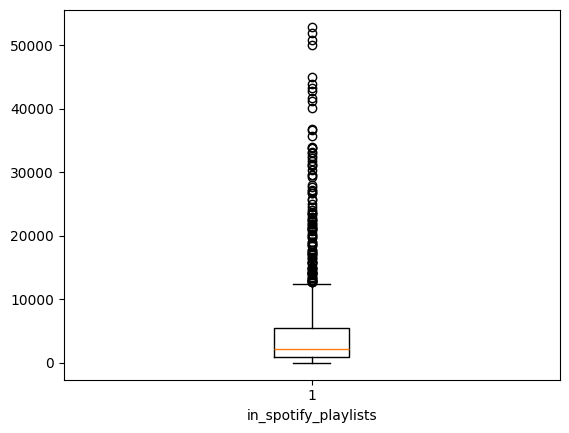

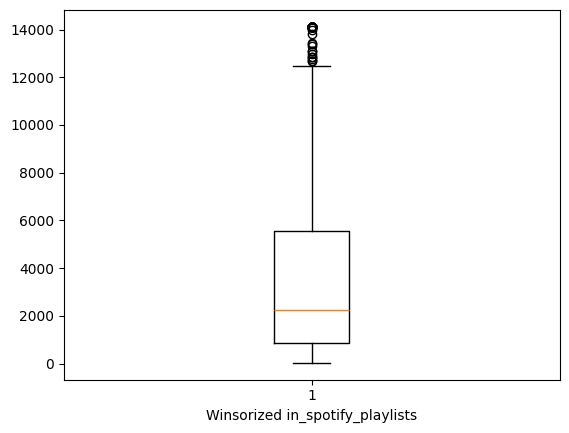

In [17]:
from scipy.stats.mstats import winsorize

#Tražimo outliere, kolona "in_spotify_playlists"
plt.boxplot(cl_data["in_spotify_playlists"])
plt.xlabel("in_spotify_playlists")
plt.show()

# ima outliere samo na gornjoj granici, winsorize u rasponu 0 - 90 ne otklanja sve outlier-e
winsorized_data = winsorize(cl_data["in_spotify_playlists"], limits=[0.00, 0.10])
plt.boxplot(winsorized_data)
plt.xlabel("Winsorized in_spotify_playlists")
plt.show()

#Zaključak je da više od 10% vrednosti ove primenljive čine outlier-i i treba je izbaciti iz dataset-a
cl_data.drop(columns = ["in_spotify_playlists"], inplace = True)

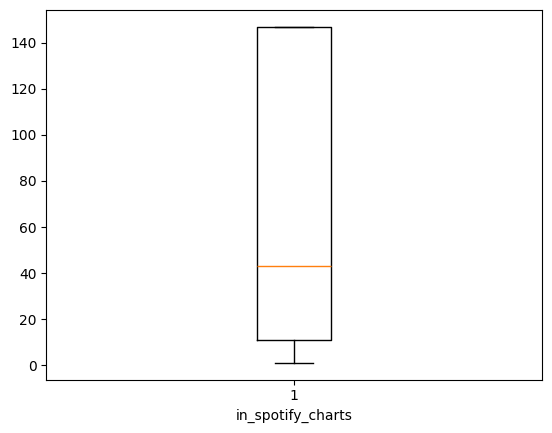

In [18]:
#Tražimo outliere, kolona "in_spotify_charts"
plt.boxplot(cl_data["in_spotify_charts"])
plt.xlabel("in_spotify_charts")
plt.show()

# Zaključak je da nema outlier-e i da ništa ne treba menjati u ovoj koloni

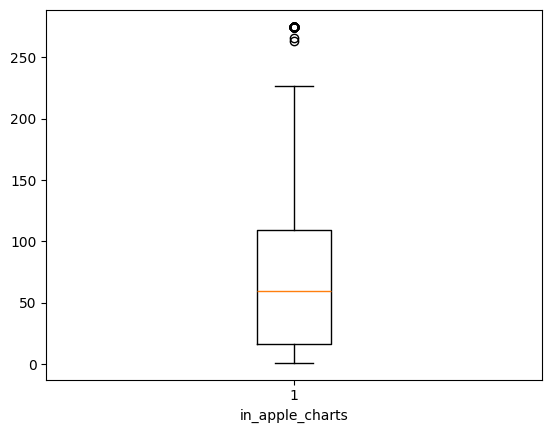

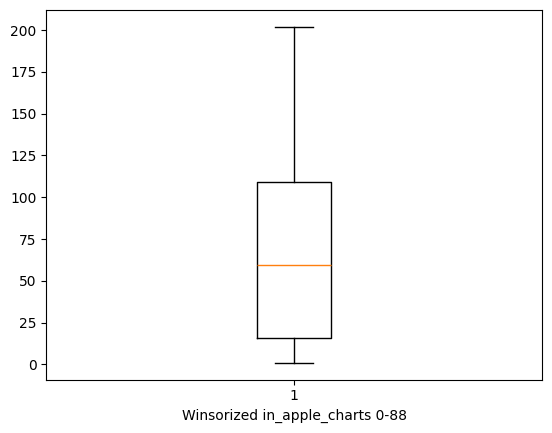

In [19]:
#Tražimo outliere, kolona "in_apple_charts"
plt.boxplot(cl_data["in_apple_charts"])
plt.xlabel("in_apple_charts")
plt.show()

# ima outliere samo na gornjoj granici, winsorize u rasponu 0 - 88 otklanja sve outlier-e
# ali to su outlier-i koje smo mi uveli kada smo nule zamenili max vrednostima
winsorized_data = winsorize(cl_data["in_apple_charts"], limits=[0.00, 0.12])
plt.boxplot(winsorized_data)
plt.xlabel("Winsorized in_apple_charts 0-88")
plt.show()

#Zaključak je da 12% vrednosti ove primenljive čine outlier-i (koje smo mi uveli zamenom nula sa
# max vrednostima) i ipak ćemo te vrednosti zameniti winsorize vrednostima
cl_data["in_apple_charts"] = winsorized_data

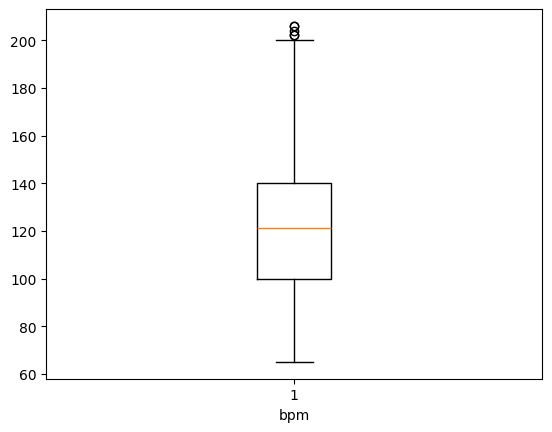

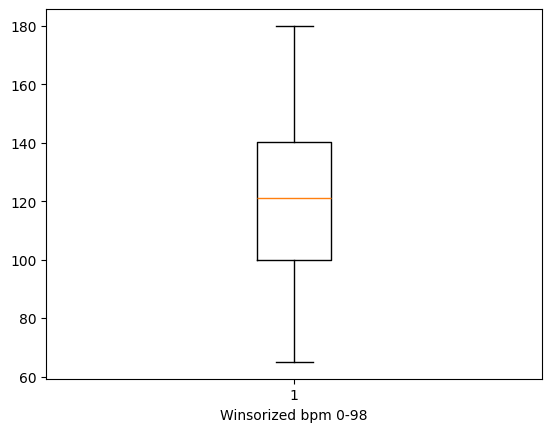

In [20]:
#Tražimo outliere, kolona "bpm"
plt.boxplot(cl_data["bpm"])
plt.xlabel("bpm")
plt.show()

# ima outliere samo na gornjoj granici, winsorize u rasponu 0 - 98 otklanja sve outlier-e
winsorized_data = winsorize(cl_data["bpm"], limits=[0.00, 0.02])
plt.boxplot(winsorized_data)
plt.xlabel("Winsorized bpm 0-98")
plt.show()

#Zaključak je da manje od 2% vrednosti ove primenljive čine outlier-i i treba te vrednosti zameniti winsorize vrednostima
cl_data["bpm"] = winsorized_data

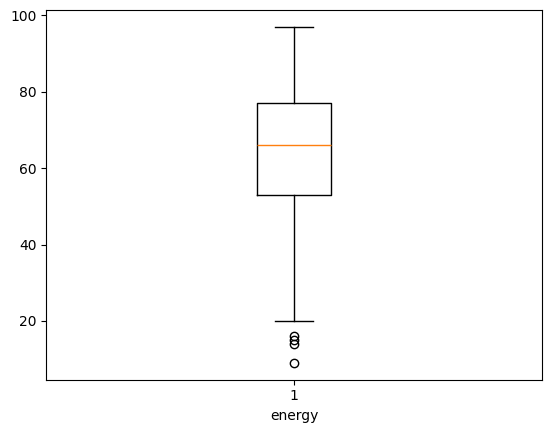

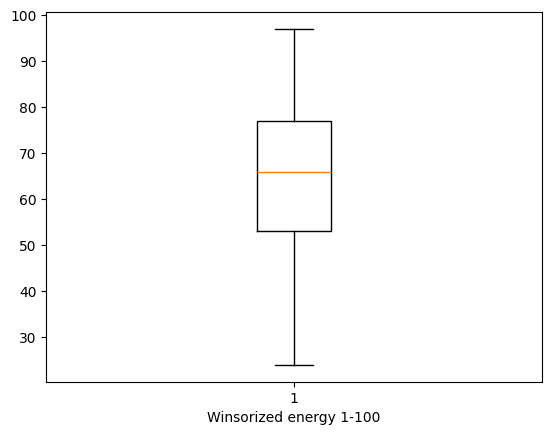

In [21]:
#Tražimo outliere, kolona "energy"
plt.boxplot(cl_data["energy"])
plt.xlabel("energy")
plt.show()

# ima outliere samo na donjoj granici, winsorize u rasponu 1 - 100 otklanja sve outlier-e
winsorized_data = winsorize(cl_data["energy"], limits=[0.01, 0.00])
plt.boxplot(winsorized_data)
plt.xlabel("Winsorized energy 1-100")
plt.show()

#Zaključak je da manje od 1% vrednosti ove primenljive čine outlier-i i treba te vrednosti zameniti winsorize vrednostima
cl_data["energy"] = winsorized_data

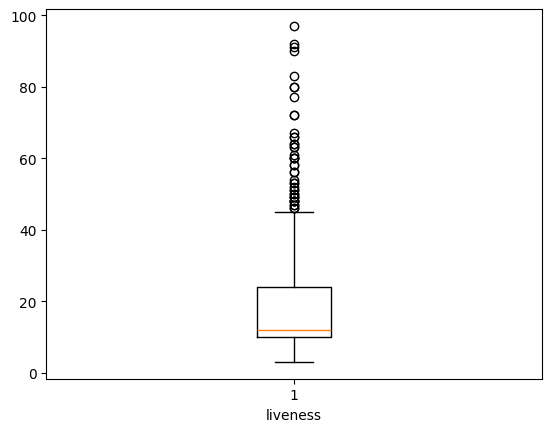

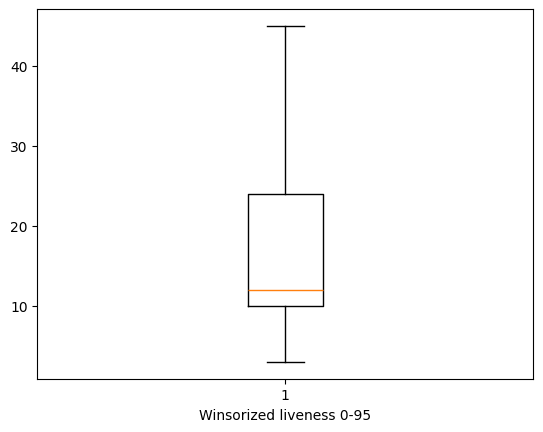

In [22]:
#Tražimo outliere, kolona "liveness"
plt.boxplot(cl_data["liveness"])
plt.xlabel("liveness")
plt.show()

# ima outliere samo na gornjoj granici, winsorize u rasponu 0 - 95 otklanja sve outlier-e
winsorized_data = winsorize(cl_data["liveness"], limits=[0.00, 0.05])
plt.boxplot(winsorized_data)
plt.xlabel("Winsorized liveness 0-95")
plt.show()

#Zaključak je da manje od 5% vrednosti ove primenljive čine outlier-i i treba te vrednosti zameniti winsorize vrednostima
cl_data["liveness"] = winsorized_data

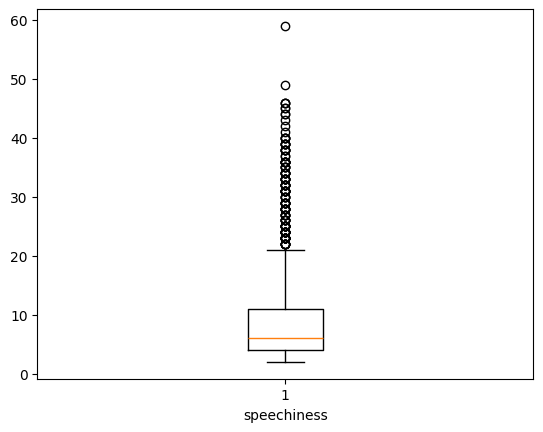

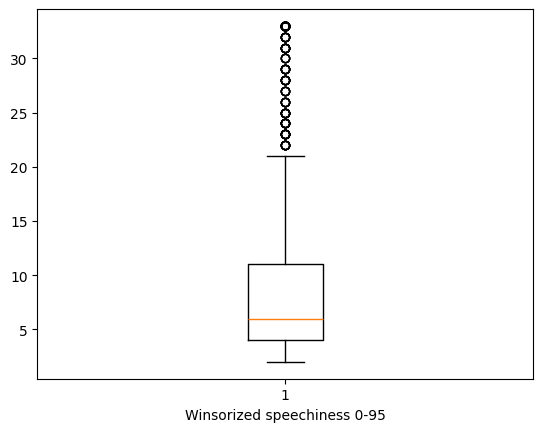

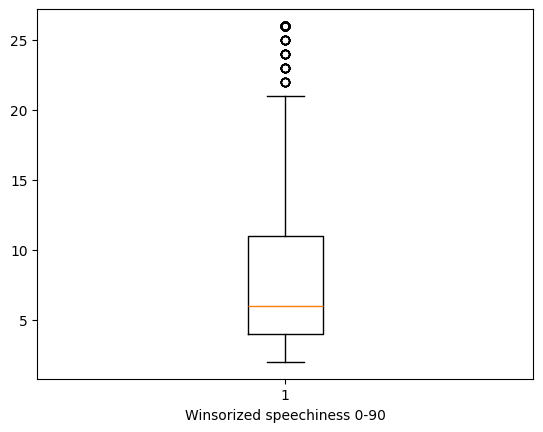

In [23]:
#Tražimo outliere, kolona "speechiness"
plt.boxplot(cl_data["speechiness"])
plt.xlabel("speechiness")
plt.show()

# ima outliere samo na gornjoj granici, winsorize u rasponu 0 - 95 NE otklanja sve outlier-e
winsorized_data = winsorize(cl_data["speechiness"], limits=[0.00, 0.05])
plt.boxplot(winsorized_data)
plt.xlabel("Winsorized speechiness 0-95")
plt.show()

# ima outliere samo na gornjoj granici, winsorize u rasponu 0 - 90 NE otklanja sve outlier-e
winsorized_data = winsorize(cl_data["speechiness"], limits=[0.00, 0.10])
plt.boxplot(winsorized_data)
plt.xlabel("Winsorized speechiness 0-90")
plt.show()

#Zaključak je da više od 10% vrednosti ove primenljive čine outlier-i i treba je izbaciti iz dataset-a
cl_data.drop(columns = ["speechiness"], inplace = True)

In [24]:
# Posle izbacivanja NA vrednosti, sređivanja i izbacivanja promenljivih sa korelacijama i outlier-ima, ostaje ovo
cl_data.describe()
# Pet promenljivih dolazi u obzir za klasterizaciju

,in_spotify_charts,in_apple_charts,bpm,energy,liveness
count,952.000000,952.000000,952.000000,952.000000,952.000000
mean,74.700630,72.967437,122.316176,64.359244,17.460084
std,64.625099,64.163222,27.490861,16.380695,11.231925
min,1.000000,1.000000,65.000000,24.000000,3.000000
25%,11.000000,16.000000,99.750000,53.000000,10.000000
50%,43.000000,59.500000,121.000000,66.000000,12.000000
75%,147.000000,109.000000,140.250000,77.000000,24.000000
max,147.000000,202.000000,180.000000,97.000000,45.000000


### 3.4 Skaliranje (normalizacija)

In [25]:
# Promenljive su u veoma različitim rasponima, potrebna je normalizacija na skalu 0-1
cl_data_scaled = cl_data.copy()

# Od svake kolonu (ćelije iz te kolone) se oduzima min vrednost te kolone, i deli
# razlikom max i min za tu kolonu, da bi se sve vrednosti svele na raspon od 0 do 1
for column in cl_data.columns:
    cl_data_scaled[column] = (cl_data_scaled[column] - cl_data_scaled[column].min()) / (cl_data_scaled[column].max() - cl_data_scaled[column].min())

# Proveravamo da li je sve skalirano kako treba (raspon od 0 do 1)
cl_data_scaled.describe()

,in_spotify_charts,in_apple_charts,bpm,energy,liveness
count,952.000000,952.000000,952.000000,952.000000,952.000000
mean,0.504799,0.358047,0.498402,0.552866,0.344288
std,0.442638,0.319220,0.239051,0.224393,0.267427
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.068493,0.074627,0.302174,0.397260,0.166667
50%,0.287671,0.291045,0.486957,0.575342,0.214286
75%,1.000000,0.537313,0.654348,0.726027,0.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000


## 4. Primenom dendrograma utvrditi najbolju vrednost za broj klastera (k) i linkage metodu

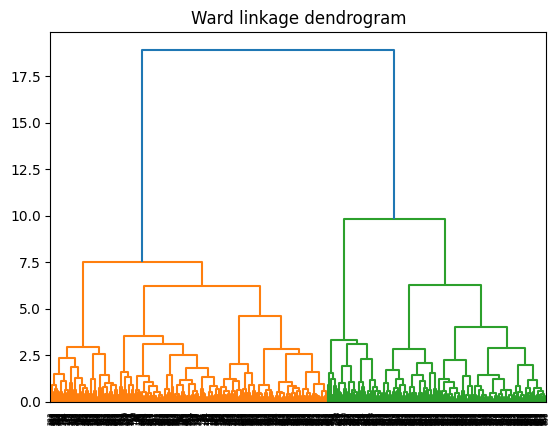

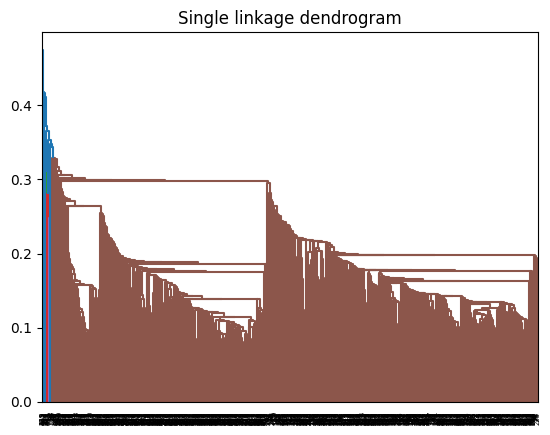

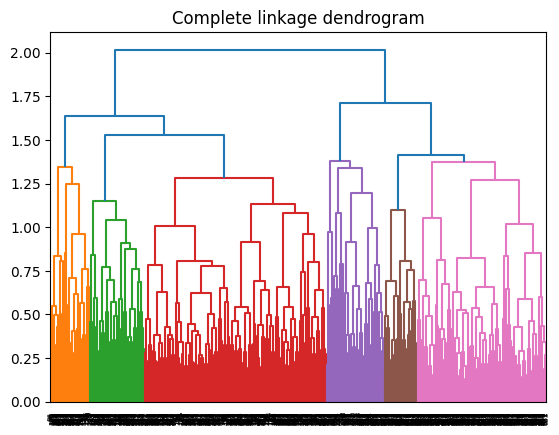

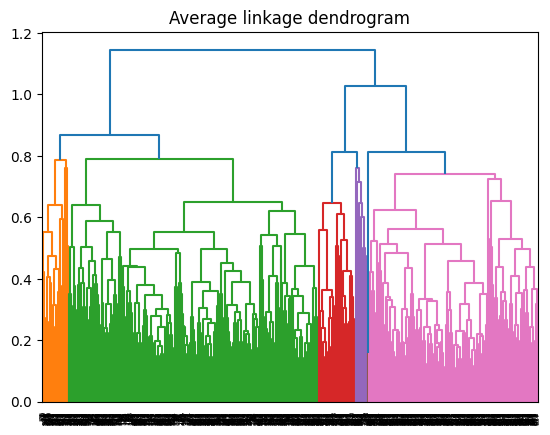

In [26]:
from scipy.cluster.hierarchy import linkage, dendrogram

#Prikaz dendrograma za različite linkage metode
dendrogram(linkage(cl_data_scaled, method='ward', metric='euclidean'))
plt.title("Ward linkage dendrogram")
plt.show()

dendrogram(linkage(cl_data_scaled, method='single', metric='euclidean'))
plt.title("Single linkage dendrogram")
plt.show()

dendrogram(linkage(cl_data_scaled, method='complete', metric='euclidean'))
plt.title("Complete linkage dendrogram")
plt.show()

dendrogram(linkage(cl_data_scaled, method='average', metric='euclidean'))
plt.title("Average linkage dendrogram")
plt.show()

# Ako se izaberu complete ili average linkage metode, dobija se
# po 6 klastera koji su dosta "bliski" jedan drugom (visine na
# dendrogramu nisu prevelike). Sa single linkage metodom, to su
# samo tri klastera ali su u velikoj neravnoteži u smislu veličine.
# Zbog svega navedenog, biramo Ward linkage metodu koja deli pesme
# u samo dva ali jasno odvojena klastera (visina na na dendrogramu
# je velika).

## 5. Izvršiti hijerarhijsku klasterizaciju za izabranu (tj. utvrđenu najbolju) vrednost za k i linkage metodu

In [28]:
# Radimo hijerarhijsku klasterizaciju sa dva klastera i Ward linkage metodom, euklidska udaljenost
h_cluster = cluster.AgglomerativeClustering(n_clusters=2, linkage = "ward", metric="euclidean").fit(cl_data_scaled)

# U dataset u kojem se nalaze originalni podaci
# (NE SKALIRANI) dodajemo novu kolonu sa oznakama koja instanca
# pripada kojem klasteru
cl_data["cluster"] = h_cluster.labels_

In [29]:
cl_data

,in_spotify_charts,in_apple_charts,bpm,energy,liveness,cluster
0,147.0,202.0,125,83,8,0
1,48.0,126.0,92,74,10,1
2,113.0,202.0,138,53,31,0
3,147.0,202.0,170,72,11,0
4,50.0,133.0,144,80,11,1
...,...,...,...,...,...,...
948,147.0,13.0,144,39,8,0
949,147.0,202.0,166,24,12,0
950,147.0,202.0,92,67,8,0
951,147.0,26.0,97,77,12,0


## 6. Interpretirati dobijene klastere (grupisane pesme) na osnovu: broja pesama, centara klastera, disperzije od centra

In [30]:
# Prvi klaster, deskriptivne statistike
cl_data[cl_data["cluster"]==0].describe()

,in_spotify_charts,in_apple_charts,bpm,energy,liveness,cluster
count,420.000000,420.000000,420.000000,420.000000,420.000000,420.0
mean,145.611905,66.723810,120.445238,62.378571,18.142857,0.0
std,8.542431,74.306916,27.761073,17.322768,11.508369,0.0
min,77.000000,1.000000,65.000000,24.000000,3.000000,0.0
25%,147.000000,8.000000,97.750000,51.000000,9.000000,0.0
50%,147.000000,30.500000,120.000000,63.000000,13.000000,0.0
75%,147.000000,106.250000,140.250000,76.000000,26.000000,0.0
max,147.000000,202.000000,180.000000,97.000000,45.000000,0.0


In [31]:
# Drugi klaster, deskrpitivne statistike
cl_data[cl_data["cluster"]==1].describe()

,in_spotify_charts,in_apple_charts,bpm,energy,liveness,cluster
count,532.000000,532.000000,532.000000,532.000000,532.000000,532.0
mean,18.718045,77.896617,123.793233,65.922932,16.921053,1.0
std,17.463317,54.416530,27.210945,15.434561,10.989696,0.0
min,1.000000,1.000000,67.000000,25.000000,4.000000,1.0
25%,5.000000,31.000000,100.000000,56.000000,10.000000,1.0
50%,13.000000,76.000000,122.000000,67.000000,12.000000,1.0
75%,28.250000,109.000000,140.250000,77.250000,22.000000,1.0
max,91.000000,202.000000,180.000000,97.000000,45.000000,1.0


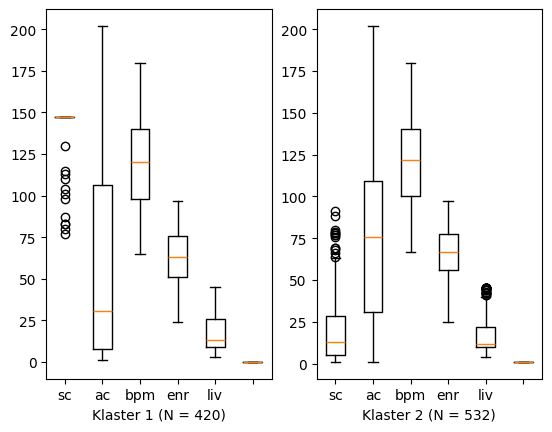

In [32]:
# Iscrtamo i uporedne boxplot-ove za ova dva klastera da bi ih uporedili u smislu sadržaja
fig, ax = plt.subplots(1,2)

ax[0].boxplot(cl_data[cl_data["cluster"]==0], tick_labels=("sc", "ac", "bpm", "enr", "liv", ""))
ax[0].set_xlabel("Klaster 1 (N = 420)")

ax[1].boxplot(cl_data[cl_data["cluster"]==1], tick_labels=("sc", "ac", "bpm", "enr", "liv", ""))
ax[1].set_xlabel("Klaster 2 (N = 532)")

plt.show()

In [ ]:
# Tumačenje

# Veličina klastera
# 1. Prvi klaster ima 420 pesama a drugi 532 klastera, oba su slične veličine.

# 2. Centri klastera
# U klasteru 1 se uglavnom nalaze pesme koje su visoko kotirane na apple rang listi (in_apple_charts) i jako loše
# kotirane na spotify rang listi. Sa druge strane, klaster 2 uglavnom sadrzi pesme koje su malo slabije kotirane na
# apple rang listi ali se dobro kotiraju na spotify rang listi. Po ostalim atributima, ove pesme se ne razlikuju
# značajno.

# 3. Disperzija od centara
# Za oba klastera možemo da kažemo da su slične homogenosti kada se uporedi standardna devijacija po kolonama
# (atributima) bpm, liveness i energy. Sa druge strane, za klaster 1 se može reći da je izuzetno homogen u
# smislu disperzije od centra klastera po atributu in_spotify_charts jer ga isključivo čine najlošije rangirane
# pesme, dok su u klasteru 2 sve ostale pesme sa te top liste, pa je homogenost manja (odnosno std veća).
# Za atribut in_apple_charts je klaster 2 malo homogeniji, ali je svakako disperzija jako velika u oba klastera,
# što znači da oba klastera sadrže pesme koje su na toj listi rangirane od najboljih do najgorih.